In [6]:
import cv2
from ultralytics import YOLO
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [7]:
video = 'videos/onions.mp4'
model = YOLO('yolov8n.pt')

cap = cv2.VideoCapture(video)
history = defaultdict(lambda: [])
all_tracks = [] # defaultdict(lambda: [])

In [8]:
while cap.isOpened:
    ret, frame = cap.read()
    if ret:

        results = model.track(frame, persist=True)

        if results[0].boxes.id is None:
            continue

        boxes = results[0].boxes.xywh.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist()
        annotation = results[0].plot()

        for box, track_id in zip(boxes, track_ids):
            x, y, w, h = box
            track = history[track_id]
            track.append((float(x), float(y)))
            if len(track) > 30:
                track.pop(0)

            points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
            all_tracks.append(points) # [track_id]
            cv2.polylines(annotation, [points], isClosed=False, color=(
                230, 230, 230), thickness=5)

        cv2.imshow("Stream: ", annotation)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:  # end of video
        break

cap.release()
cv2.destroyAllWindows()


0: 640x384 1 person, 170.6ms
Speed: 10.0ms preprocess, 170.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 141.6ms
Speed: 7.0ms preprocess, 141.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 129.2ms
Speed: 5.0ms preprocess, 129.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 117.1ms
Speed: 3.0ms preprocess, 117.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 124.2ms
Speed: 5.0ms preprocess, 124.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 119.3ms
Speed: 6.0ms preprocess, 119.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 108.2ms
Speed: 6.0ms preprocess, 108.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 110.2ms
Speed: 7.0ms preprocess, 110.2ms inference, 2.0ms postprocess per image a

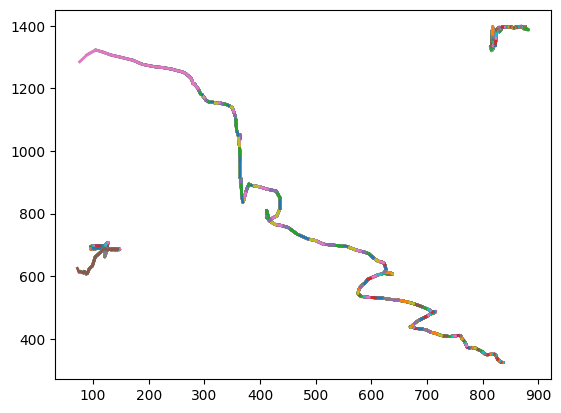

In [9]:
if all_tracks:
    fig, ax = plt.subplots()
    for points in all_tracks:
        ax.plot(points[:, 0, 0], points[:, 0, 1], linewidth=2)
    plt.savefig('output_plot.png')

TypeError: list indices must be integers or slices, not tuple

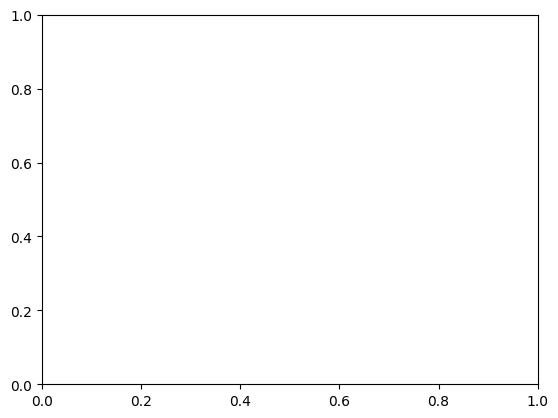

In [5]:
if all_tracks:
    fig, ax = plt.subplots()

    for track_id, points in all_tracks.items():
        ax.plot(points[:, 0, 0], points[:, 0, 1], linewidth=2)
    plt.savefig('output_plot.png')